In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd /content/drive/MyDrive/AML/AML_course/Project

/content/drive/MyDrive/AML/AML_course/Project


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import shutil
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import scipy.io
import json
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import random
from tqdm import tqdm
import numpy as np
from modules.data_preprocessing import data_reallocation, create_datasets
from modules.train_classfier import train, test_eval
from modules.generate_images import generate_from_prompt


In [11]:
%cd /content

/content


### Data preprocessing

In [12]:
import gdown
url = "https://drive.google.com/drive/folders/1c2xufL1sNJHbQ3v3b5l1jmYx86ahDgLQ"

gdown.download_folder(url, output='flower102')

Retrieving folder contents


Processing file 1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID 102flowers.tgz
Processing file 1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL cat_to_name.json
Processing file 1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn imagelabels.mat
Processing file 1m8mSQlD27WR2vHp-PkiQ_17ts408xn10 setid.mat


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID
From (redirected): https://drive.google.com/uc?id=1NVV3x5bnHk0kDnxQuCtjJFrVdVSh96ID&confirm=t&uuid=0973216f-d8c1-4b0b-9606-e928b86637c6
To: /content/flower102/102flowers.tgz
100%|██████████| 345M/345M [00:03<00:00, 100MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kW4gIHlC82lDDdPRNf-ib1go1ekM05mL
To: /content/flower102/cat_to_name.json
100%|██████████| 2.22k/2.22k [00:00<00:00, 3.68MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn
From (redirected): https://drive.google.com/uc?id=1thBhdGC6oJywetBBiFcmh5OI7mX9DpGn&confirm=t&uuid=e1b0ceab-ddbe-4b09-ab0b-482e2487d4d7
To: /content/flower102/imagelabels.mat
100%|██████████| 502/502 [00:00<00:00, 1.49MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1m8mSQlD27W

['flower102/102flowers.tgz',
 'flower102/cat_to_name.json',
 'flower102/imagelabels.mat',
 'flower102/setid.mat']

In [13]:
import tarfile
source_path = "flower102/102flowers.tgz"
destination_path = "flower102"

with tarfile.open(source_path, "r:gz") as tar:
      tar.extractall(path=destination_path)

os.remove(source_path)

In [14]:
# Define paths
data_path = 'flower102'
images_path = os.path.join(data_path, 'jpg')
output_path = 'data'

data_reallocation(data_path,
                  images_path,
                  output_path)

Images reallocated successfully to folder data


In [43]:
train_dataset, val_dataset, test_dataset = create_datasets(output_path, batch_size=32)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

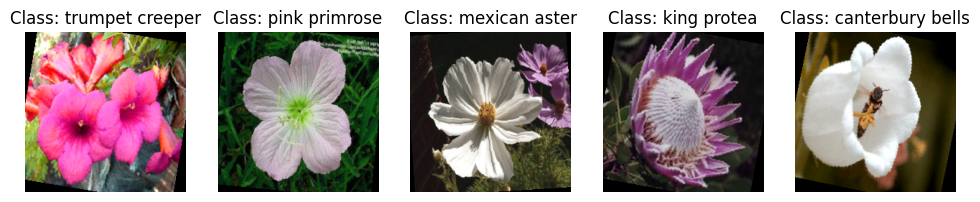

In [44]:
# plot 4 images from data
swapped_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for ax in axes:
    picture_number = random.randint(0, len(train_dataset))
    image = train_dataset[picture_number][0].permute(1, 2, 0)
    #unnormalize
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    ax.imshow(image)
    ax.set_title(f"Class: {swapped_dict[train_dataset[picture_number][1]]}")
    ax.axis('off')


### Classification model training and evaluation

In [52]:
model = torchvision.models.resnet50(pretrained=True)
num_epochs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss()
path_to_save_model = 'model.pth'
lr = 0.001
num_classes = len(train_loader.dataset.classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


Val: Epoch [1/8], n\Loss: 3.7384, n\Accuracy: 23.8235


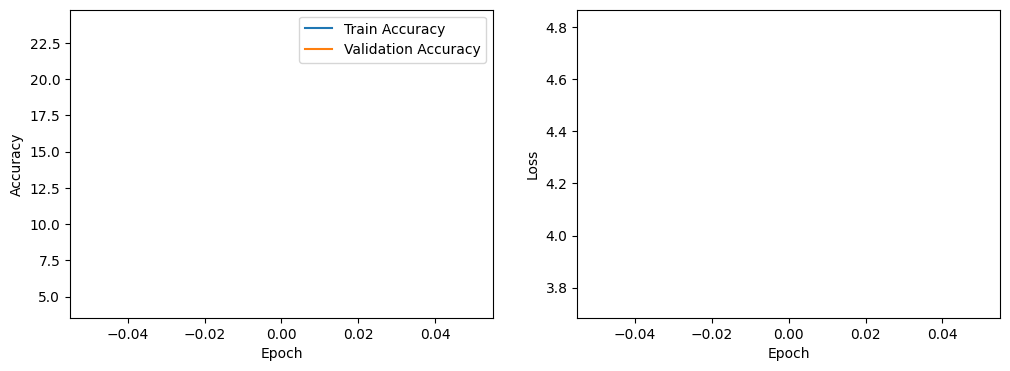

Val: Epoch [2/8], n\Loss: 2.7458, n\Accuracy: 46.9608


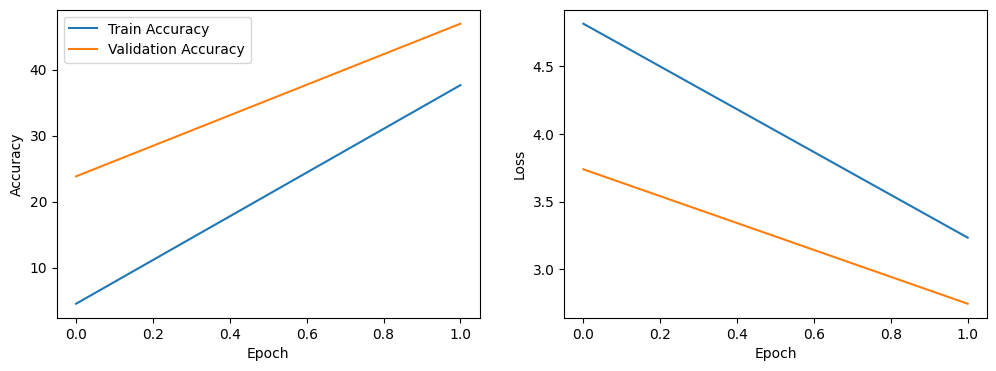

Val: Epoch [3/8], n\Loss: 2.1357, n\Accuracy: 58.6275


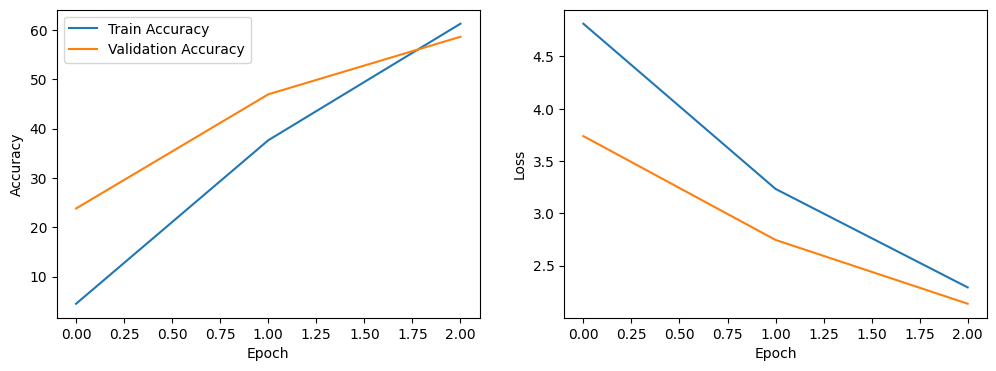

Val: Epoch [4/8], n\Loss: 1.7235, n\Accuracy: 69.9020


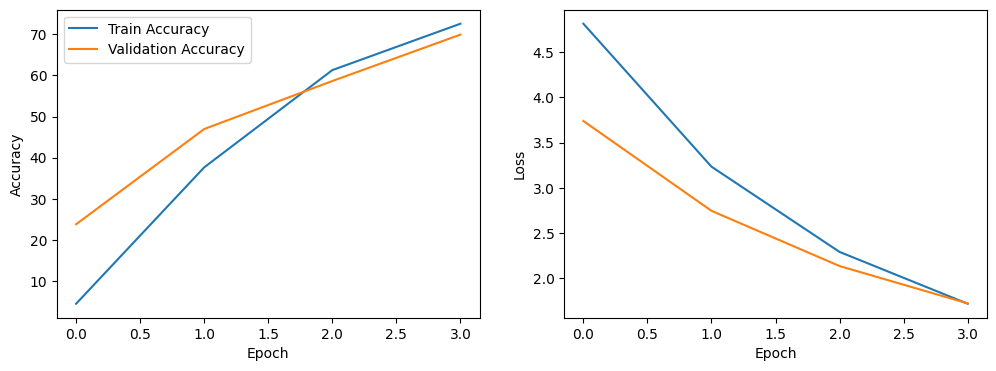

Val: Epoch [5/8], n\Loss: 1.4902, n\Accuracy: 68.5294


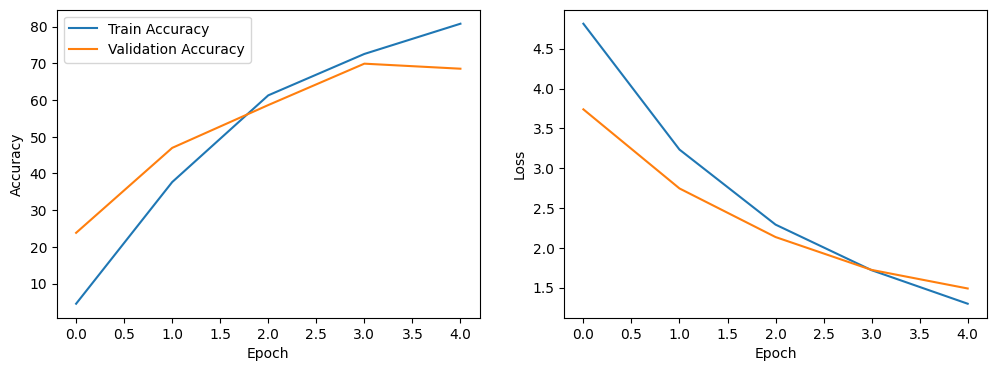

Val: Epoch [6/8], n\Loss: 1.3132, n\Accuracy: 73.1373


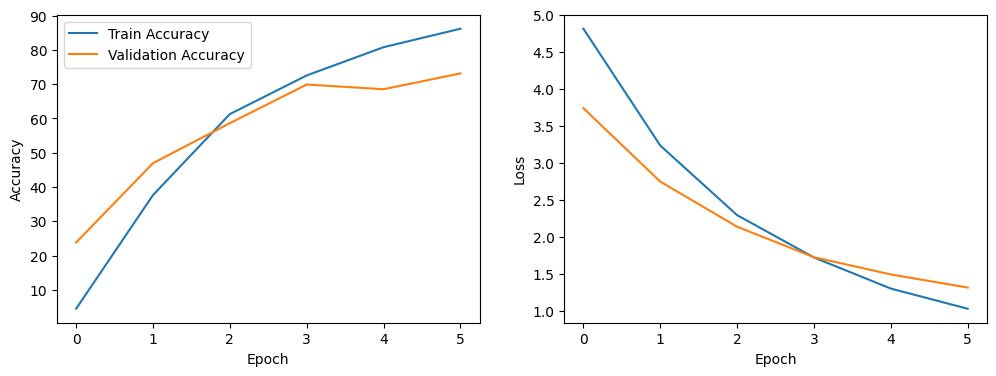

Val: Epoch [7/8], n\Loss: 1.2121, n\Accuracy: 74.6078


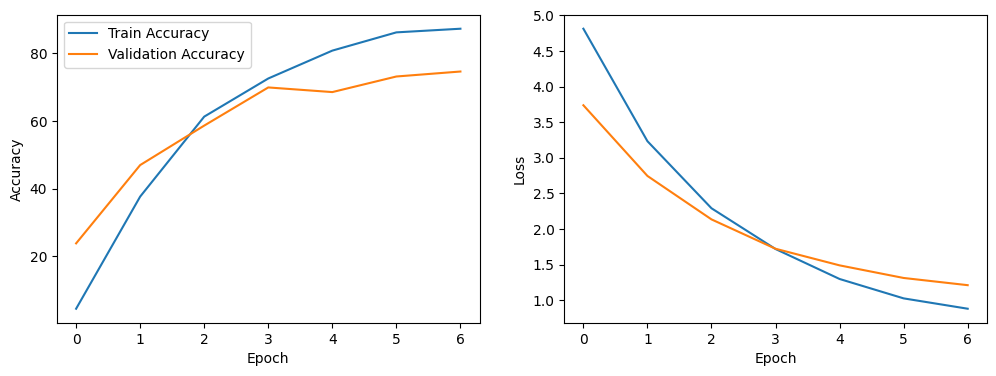

Val: Epoch [8/8], n\Loss: 1.1446, n\Accuracy: 75.0980


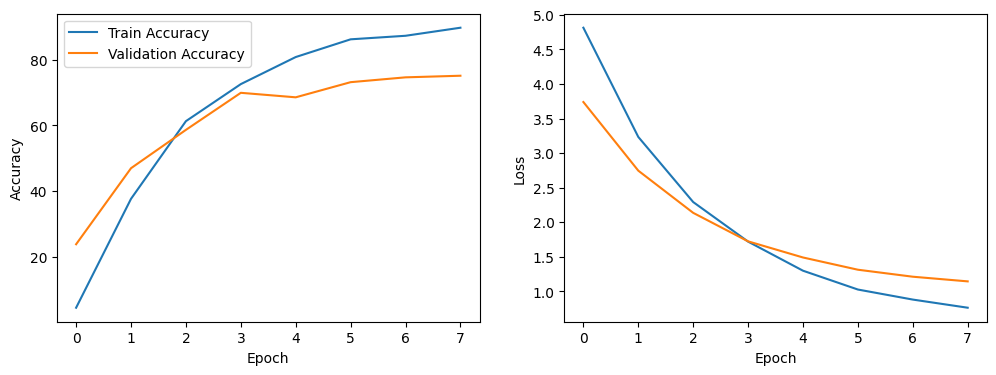

In [9]:
train(train_loader,
      val_loader,
      model = model,
      num_epochs = num_epochs,
      device = device,
      criterion = criterion,
      optimizer = optimizer,
      lr = lr,
      path_to_save_model = path_to_save_model,
      num_classes = num_classes)

In [10]:
test_eval(test_loader,
    model = model,
    device = device,
    path_to_save_model = path_to_save_model)

/content/drive/MyDrive/AML/AML_course/Project/modules/train_classfier.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_to_save_mod

Test Accuracy: 70.1090


### Worst performing class

#### Load saved model

In [49]:
#saved model
from torchvision import models
file_id = '1-m3nC5im8MtNBaajab8OTm7I33voeVsi'
output = 'model.pth'
gdown.download(id=file_id, output=output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-m3nC5im8MtNBaajab8OTm7I33voeVsi
From (redirected): https://drive.google.com/uc?id=1-m3nC5im8MtNBaajab8OTm7I33voeVsi&confirm=t&uuid=1b84fcc4-414f-4643-9cc1-292576d3809c
To: /content/model.pth
100%|██████████| 95.2M/95.2M [00:00<00:00, 164MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-49-1659cee0eccf>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It

<All keys matched successfully>

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 102) # 102 is the number of classes in flower102
model.load_state_dict(torch.load(output))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#### Calculate metrics

In [56]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

  0%|          | 0/32 [00:00<?, ?it/s]

In [65]:
cm = confusion_matrix(all_labels, all_preds)
class_f1 = []
class_precision = []
class_recall = []

for i in range(num_classes):
  precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:,i]) > 0 else 0
  recall = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i,:]) > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
  class_f1.append(f1)
  class_precision.append(precision)
  class_recall.append(recall)

In [15]:
# Find the class with the worst accuracy and F1-score
worst_class = np.argmin(class_f1)

print(f"Class with worst validation F1: {swapped_dict[worst_class]}, F1: {class_f1[worst_class]}")


Class with worst validation F1: azalea, F1: 0.18181818181818182


In [67]:

worst_classes_indices = np.argsort(class_f1)[:10]

print("10 Classes with worst validation F1:")
for i in worst_classes_indices:
    print(f"Class: {swapped_dict[i]}, {i} F1: {class_f1[i]:.4f}, precision: {class_recall[i]:.4f}, recall: {class_recall[i]:.4f}")

10 Classes with worst validation F1:
Class: azalea, 3 F1: 0.1818, precision: 0.1000, recall: 0.1000
Class: monkshood, 60 F1: 0.1818, precision: 0.1000, recall: 0.1000
Class: mexican petunia, 59 F1: 0.1818, precision: 0.1000, recall: 0.1000
Class: clematis, 25 F1: 0.3333, precision: 0.2000, recall: 0.2000
Class: canna lily, 20 F1: 0.3636, precision: 0.4000, recall: 0.4000
Class: sweet pea, 87 F1: 0.3846, precision: 0.5000, recall: 0.5000
Class: ruby-lipped cattleya, 79 F1: 0.4000, precision: 0.3000, recall: 0.3000
Class: snapdragon, 82 F1: 0.4286, precision: 0.3000, recall: 0.3000
Class: japanese anemone, 50 F1: 0.4615, precision: 0.3000, recall: 0.3000
Class: lenten rose, 52 F1: 0.4615, precision: 0.3000, recall: 0.3000


In [86]:
worst_class = worst_classes_indices[2]
worst_class

59

In [87]:
indices = np.where(all_labels == worst_class)[0]
preds_worst_class = np.array(all_preds)[indices]
[swapped_dict[i] for i in preds_worst_class]

['petunia',
 'pink primrose',
 'pelargonium',
 'bougainvillea',
 'mexican petunia',
 'stemless gentian',
 'balloon flower',
 'pink primrose',
 'giant white arum lily',
 'hibiscus']

In [ ]:
#add counting of unique categories class was confused with

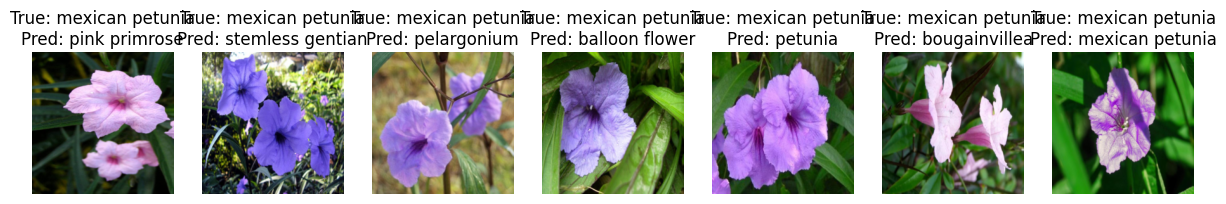

In [88]:
worst_class_indices = [i for i, (img, label) in enumerate(val_dataset) if label == worst_class]

num_images_to_display = 7
selected_indices = np.random.choice(worst_class_indices, size=min(num_images_to_display, len(worst_class_indices)), replace=False)

fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i, idx in enumerate(selected_indices):
    image, label = val_dataset[idx]
    image = image.permute(1, 2, 0)* torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    predicted_label = all_preds[idx]
    axes[i].imshow(image)
    axes[i].set_title(f"True: {swapped_dict[label]}\nPred: {swapped_dict[predicted_label]}")
    axes[i].axis('off')

plt.show()

### Sampling from raw StableDiffusion with prompts

In [89]:
swapped_dict[worst_class]

'mexican petunia'

In [90]:
model_id = "stabilityai/stable-diffusion-2"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [91]:
output_dir = 'raw_model_examples' + swapped_dict[worst_class]
os.makedirs(output_dir, exist_ok=True)

generate_from_prompt(model_id = model_id,
                     prompt = f"A close photo of a {swapped_dict[worst_class]}",
                     device = device,
                     output_dir = output_dir,
                     num_images = 10)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_0.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_1.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_2.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_3.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_4.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_5.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_6.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_7.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_8.png


  0%|          | 0/50 [00:00<?, ?it/s]

Image saved at raw_model_examplesmexican petunia/a_close_photo_of_a_mexican_petunia_9.png


In [94]:
# !pip install torcheval
from torcheval import metrics
fid_metric = metrics.FrechetInceptionDistance(device = device)

In [95]:
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Normalize

transform = Resize((299, 299))
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = ToTensor()(image)
    tensor = transform(tensor)
    tensor = normalize(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

In [96]:
path_to_real_images = os.path.join('data/val', swapped_dict[worst_class])
path_to_real_images_train = os.path.join('data/train', swapped_dict[worst_class])

fake_images = torch.stack([preprocess_image(os.path.join(output_dir, filename)) for filename in os.listdir(output_dir)])
real_images = torch.stack([preprocess_image(os.path.join(path_to_real_images, filename)) for filename in os.listdir(path_to_real_images)])
real_images_train = torch.stack([preprocess_image(os.path.join(path_to_real_images_train, filename)) for filename in os.listdir(path_to_real_images_train)])

fid_metric.update(real_images, is_real=True)
# fid_metric.update(real_images_train, is_real=True)
fid_metric.update(fake_images, is_real=False)

In [97]:
fid_metric.compute()

tensor(258.7234, device='cuda:0')

In [ ]:
# output_dir = 'drive/MyDrive/AML/raw_model_examples'

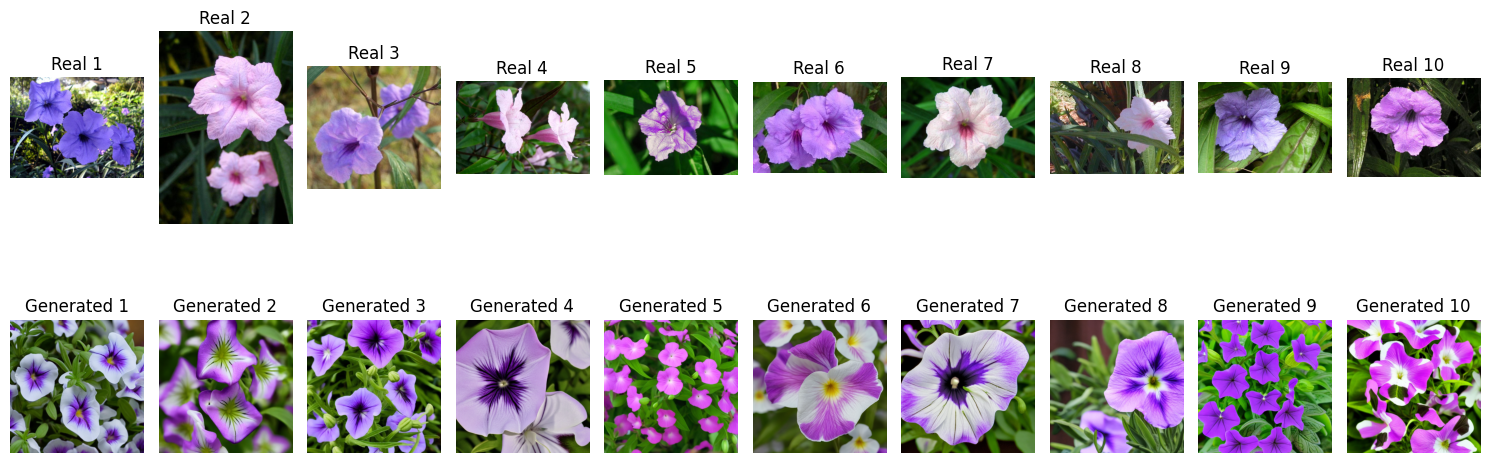

In [98]:

num_images_to_display = min(len(os.listdir(output_dir)), len(os.listdir(path_to_real_images)))
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))

# Display real images
for i, filename in enumerate(os.listdir(path_to_real_images)[:num_images_to_display]):
    image_path = os.path.join(path_to_real_images, filename)
    img = Image.open(image_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Real {i+1}")
    axes[0, i].axis('off')

# Display generated images
for i, filename in enumerate(os.listdir(output_dir)[:num_images_to_display]):
    image_path = os.path.join(output_dir, filename)
    img = Image.open(image_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Generated {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Textual inversion

In [2]:
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate transformers ftfy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.4 MB/s eta 0:00:00
  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl for URL https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl


In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
# swapped_dict = {15: "azalea"}
# worst_class = 15
# swapped_dict[worst_class]

'azalea'

In [16]:
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from packaging import version

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [17]:
#prepare data for textual inversion
data_path = f"data/train/{swapped_dict[worst_class]}"
save_path = "textual_inversion_images"
os.makedirs(save_path, exist_ok=True)

for filename in os.listdir(data_path):
    source_path = os.path.join(data_path, filename)
    destination_path = os.path.join(save_path, filename)
    if os.path.isfile(source_path):
        shutil.copy2(source_path, destination_path)

In [18]:
what_to_teach = "object"
placeholder_token = f"<{swapped_dict[worst_class]}>"
initializer_token = swapped_dict[worst_class]

In [19]:
#prompt templates for training
imagenet_templates_small = [
    "a photo of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the weird {}",
    "a photo of a cool {}"
]

In [20]:
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        if version.parse(version.parse(PIL.__version__).base_version) >= version.parse("9.1.0"):
            PIL_INTERPOLATION = {
                "linear": PIL.Image.Resampling.BILINEAR,
                "bilinear": PIL.Image.Resampling.BILINEAR,
                "bicubic": PIL.Image.Resampling.BICUBIC,
                "lanczos": PIL.Image.Resampling.LANCZOS,
                "nearest": PIL.Image.Resampling.NEAREST,
            }
        else:
            PIL_INTERPOLATION = {
                "linear": PIL.Image.LINEAR,
                "bilinear": PIL.Image.BILINEAR,
                "bicubic": PIL.Image.BICUBIC,
                "lanczos": PIL.Image.LANCZOS,
                "nearest": PIL.Image.NEAREST,
                }

        self.interpolation = PIL_INTERPOLATION[interpolation]

        self.templates = imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [21]:
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2"

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

In [22]:
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [23]:
token_ids

[34087]

In [24]:
# Load models and create wrapper for stable diffusion
# pipeline = StableDiffusionPipeline.from_pretrained(pretrained_model_name_or_path)
# del pipeline
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

In [25]:
text_encoder.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(49409, 1024)

In [26]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [27]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [28]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

<ipython-input-28-fb25fea1ebcb>:4: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,


In [29]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [30]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

In [31]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-concept-output"
}
!mkdir -p sd-concept-output

In [32]:
#@title Training function
logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [33]:
import accelerate
# !apt install -y nvidia-cuda-toolkit
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [35]:
save_concept_to_public_library = True
name_of_your_concept = f"{swapped_dict[worst_class]} flowers102" #param {type:"string"}
#markdown `hf_token_write`: leave blank if you logged in with a token with `write access` in the [Initial Setup](#scrollTo=KbzZ9xe6dWwf). If not, [go to your tokens settings and create a write access token](https://huggingface.co/settings/tokens)
hf_token_write = "" #param {type:"string"}

if(save_concept_to_public_library):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  output_dir = hyperparameters["output_dir"]
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write
  #Join the Concepts Library organization if you aren't part of it already
  !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-concepts-library/share/VcLXJtzwwxnHYCkNMLpSJCdnNFZHQwWywv
  images_upload = os.listdir("textual_inversion_images")
  image_string = ""
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![{placeholder_token} {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  if(what_to_teach == "style"):
      what_to_teach_article = f"a `{what_to_teach}`"
  else:
      what_to_teach_article = f"an `{what_to_teach}`"
  readme_text = f'''---
license: mit
base_model: {pretrained_model_name_or_path}
---
### {name_of_your_concept} on Stable Diffusion
This is the `{placeholder_token}` concept taught to Stable Diffusion via Textual Inversion. You can load this concept into the [Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) notebook. You can also train your own concepts and load them into the concept libraries using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

Here is the new concept you will be able to use as {what_to_teach_article}:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(placeholder_token)
  text_file.close()
  #Save the type of teached thing to a file
  type_file = open("type_of_concept.txt","w")
  type_file.write(what_to_teach)
  type_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="learned_embeds.bin", path_or_fileobj=f"{output_dir}/learned_embeds.bin"),
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="type_of_concept.txt", path_or_fileobj="type_of_concept.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  create_repo(repo_id,private=True, token=hf_token)
  api = HfApi()
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )

Found. Redirecting to /sd-concepts-library?message=You're%20already%20a%20member%20of%20sd-concepts-library!

learned_embeds.bin:   0%|          | 0.00/5.31k [00:00<?, ?B/s]

### Sampling from StableDiffusion with prompt using new token

In [99]:

from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    scheduler=DPMSolverMultistepScheduler.from_pretrained(hyperparameters["output_dir"], subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

OSError: sd-concept-output is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `token` or log in with `huggingface-cli login`.

In [41]:
prompt = f"A photo of a {placeholder_token}"


num_samples = 5
num_rows = 1

all_images = []

output_dir = 'trained_model_examples'
os.makedirs(output_dir, exist_ok=True)
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=30, guidance_scale=7.5).images
    all_images.extend(images)

    # Save images to the specified directory
    for i, image in enumerate(images):
        name = f"{prompt.lower().replace(' ', '_')}_{_+i}.png"
        image_path = os.path.join(output_dir, name)
        image.save(image_path)

grid = image_grid(all_images, num_rows, num_samples)
grid

Output hidden; open in https://colab.research.google.com to view.